In [1]:
import illustris_python as il
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KDTree
import matplotlib 
from statsmodels.nonparametric.smoothers_lowess import lowess
import os
import seaborn as sns

matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13

### set binning

In [2]:
bin_number = 14
bin_edges = 10 ** np.linspace(1.0, 2.845, num=bin_number + 1)

areas = np.array([])
for i in range(len(bin_edges[:-1])):
    areas = np.append(areas, (bin_edges[i + 1] ** 2 - bin_edges[i] ** 2) * np.pi)

### projected profiles

In [5]:
def radial(massive_central_halos,subhalos,z,sat_cut_low,sat_cut_high, proj_collapse=0):
    proj = np.delete(np.array([0,1,2]),proj_collapse)
    
    # cosmological scale factor
    a=1/(1+z)
    sat_masscut = 10**(sat_cut_low-10)
    sat_masscut_high = 10**(sat_cut_high-10)

    # satellite galaxy mass cut logM=9.5
    subhalos_masscut = subhalos[subhalos['SubhaloStellarPhotometricsMassInRad']>sat_masscut*0.704]  # x*10^10 M_sun / h
    subhalos_masscut = subhalos_masscut[subhalos_masscut['SubhaloStellarPhotometricsMassInRad']<sat_masscut_high*0.704]
    
    tree = KDTree(subhalos_masscut['SubhaloPos'])
    tree_2d = KDTree(subhalos_masscut['SubhaloPos'][:,proj])

    radial_tot = np.zeros(bin_number)
    massive_count = 0
    for halo in massive_central_halos:
        # find the subhalo that host central galaxy
        first_subhalo = subhalos[halo['GroupFirstSub']]
    
        # cylinder shape selection
        ind = tree_2d.query_radius([halo['GroupPos'][proj]],bin_edges[-1]/a*0.704,count_only=False) # comoving kpc / h
        cat_neighbors = subhalos_masscut[ind[0]]
        cat_neighbors = cat_neighbors[abs(cat_neighbors['SubhaloPos'][:,proj_collapse]-halo['GroupPos'][proj_collapse])<bin_edges[-1]*1*0.704]
    
        # isolation criteria
        cat_massive_neighbors = cat_neighbors[cat_neighbors['SubhaloStellarPhotometricsMassInRad']>first_subhalo['SubhaloStellarPhotometricsMassInRad']]
        if len(cat_massive_neighbors)>=2:
            continue
        elif len(cat_neighbors)==0:
            continue 
    
        # do the measurement
        radial = []    
        subtree = KDTree(cat_neighbors['SubhaloPos'][:,proj])
        for bin_edge in bin_edges:
            ind = subtree.query_radius([halo['GroupPos'][proj]],bin_edge/a*0.704,count_only=True) # comoving kpc / h
            radial.append(ind[0])
        
        radial = np.diff(np.array(radial))
        radial_tot += radial
        massive_count += 1
    
    print('massive gals:',len(massive_central_halos),', isolated centrals:',massive_count)
    return radial_tot, np.sqrt(radial_tot), massive_count

def load_subhalo_halo(basePath, snap, cen_cut):
    header = il.groupcat.loadHeader(basePath,72)
    boxsize = header['BoxSize']
    central_masscut = 10**(cen_cut-10)
    
    # load subhalos
    fields = ['SubhaloPos','SubhaloMass','SubhaloStellarPhotometricsMassInRad','SubhaloStellarPhotometrics','SubhaloSFR']
    subhalos = il.groupcat.loadSubhalos(basePath,snap,fields=fields)
    del subhalos['count']
    subhalos = Table(subhalos)

    # load halos
    halos = il.groupcat.loadHalos(basePath,snap,fields=['GroupFirstSub','GroupPos'])
    del halos['count']
    halos = Table(halos)
    
    # cut massive galaxies
    halos = halos[halos['GroupFirstSub']<10000000]
    first_subhalos = subhalos[halos['GroupFirstSub']]
    massive_central_halos = halos[first_subhalos['SubhaloStellarPhotometricsMassInRad']>central_masscut*0.704]
    
    # cut off centrals that are close to edge
    mask = []
    for halo in massive_central_halos:
        central_on_edge = False
        for i in range(3):
            if abs(boxsize/2-subhalos[halo['GroupFirstSub']]['SubhaloPos'][i])>boxsize/2-bin_edges[-1]:
                central_on_edge = True
            
        if central_on_edge == True: 
            mask.append(False)
        else:
            mask.append(True)
    
    massive_central_halos = massive_central_halos[mask]
    return massive_central_halos, subhalos

massive gals: 683 , isolated centrals: 683
massive gals: 5317 , isolated centrals: 5316


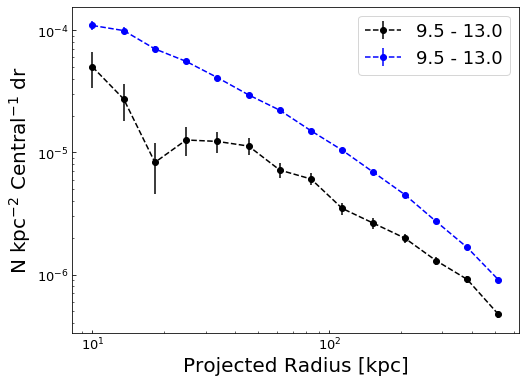

In [10]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

path = 'sims.illustris/Illustris-1/output'
m_il,s_il=load_subhalo_halo(path,134,10.8)
path = 'sims.TNG/TNG300-1/output/'
m_tng,s_tng=load_subhalo_halo(path,99,10.8)

radial_tot_il,radial_tot_il_err, count_il = radial(m_il,s_il,0,9.5,13.0)
radial_tot_tng,radial_tot_tng_err, count_tng = radial(m_tng,s_tng,0,9.5,13.0)

plt.errorbar(bin_edges[:-1],radial_tot_il/areas/count_il 
             yerr=radial_tot_il_err/areas/count_il,fmt='ok--',label='9.5 - 13.0')
plt.errorbar(bin_edges[:-1],radial_tot_tng/areas/count_tng,
             yerr=radial_tot_tng_err/areas/count_tng,fmt='ob--',label='9.5 - 13.0')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('compare_IL_TNG.png')


massive gals: 210 , isolated centrals: 210
massive gals: 210 , isolated centrals: 210
massive gals: 210 , isolated centrals: 210


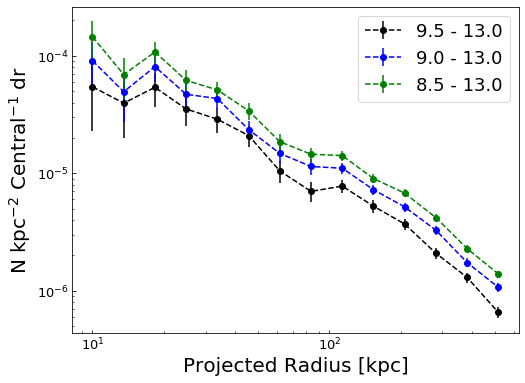

In [7]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

path = 'sims.illustris/Illustris-1/output'
m_il,s_il=load_subhalo_halo(path,108,11.15)

radial_tot_il,radial_tot_il_err, count_il = radial(m_il,s_il,0.4,9.5,13.0)
radial_tot_il2,radial_tot_il2_err, count_il2 = radial(m_il,s_il,0.4,9.0,13.0)
radial_tot_il3,radial_tot_il3_err, count_il3 = radial(m_il,s_il,0.4,8.5,13.0)

plt.errorbar(bin_edges[:-1],radial_tot_il/areas/count_il,yerr=radial_tot_il_err/areas/count_il,fmt='ok--',label='9.5 - 13.0')
plt.errorbar(bin_edges[:-1],radial_tot_il2/areas/count_il2,yerr=radial_tot_il2_err/areas/count_il2,fmt='ob--',label='9.0 - 13.0')
plt.errorbar(bin_edges[:-1],radial_tot_il3/areas/count_il3,yerr=radial_tot_il3_err/areas/count_il3,fmt='og--',label='8.5 - 13.0')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('compare_IL_sat_masscut.png')


massive gals: 226 , isolated centrals: 145
massive gals: 226 , isolated centrals: 226


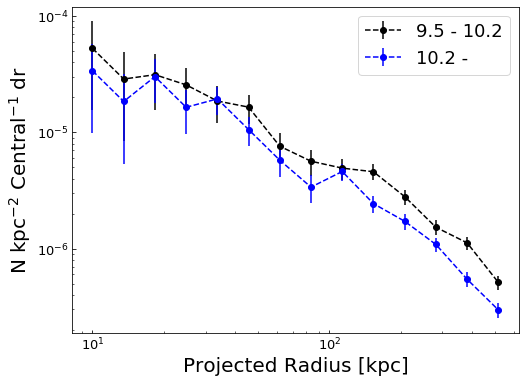

In [23]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

m_il,s_il=load_subhalo_halo('./sims.illustris/Illustris-1/output',108,11.15)
radial_tot_il,radial_tot_il_err ,count_il = radial(m_il,s_il,0.4,9.5,10.2)
radial_tot_il2, radial_tot_il2_err,count_il2 = radial(m_il,s_il,0.4,10.2,13.0)

plt.errorbar(bin_edges[:-1],radial_tot_il/areas/count_il,yerr=radial_tot_il_err/areas/count_il,fmt='ok--',label='9.5 - 10.2')
plt.errorbar(bin_edges[:-1],radial_tot_il2/areas/count_il2,yerr=radial_tot_il2_err/areas/count_il2,fmt='ob--',label='10.2 - ')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('split_sat_mass_IL.png')

massive gals: 767 , isolated centrals: 764
massive gals: 767 , isolated centrals: 762
massive gals: 767 , isolated centrals: 493


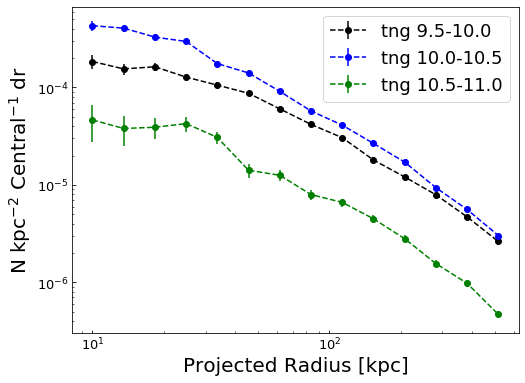

In [24]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

m_il,s_il=load_subhalo_halo('sims.TNG/TNG300-1/output/',72, 11.15)
radial_tot_tng,radial_tot_tng_err, count_tng = radial(m_il,s_il,0.4,8.0,9.0)
radial_tot_tng2,radial_tot_tng2_err, count_tng2 = radial(m_il,s_il,0.4,9.0,11.0)
radial_tot_tng3,radial_tot_tng3_err, count_tng3 = radial(m_il,s_il,0.4,10.5,11.0)

plt.errorbar(bin_edges[:-1],radial_tot_tng/areas/count_tng,yerr=radial_tot_tng_err/areas/count_tng,fmt='ok--',label='tng 9.5-10.0')
plt.errorbar(bin_edges[:-1],radial_tot_tng2/areas/count_tng2,yerr=radial_tot_tng2_err/areas/count_tng2,fmt='ob--',label='tng 10.0-10.5')
plt.errorbar(bin_edges[:-1],radial_tot_tng3/areas/count_tng3,yerr=radial_tot_tng3_err/areas/count_tng3,fmt='og--',label='tng 10.5-11.0')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('split_sat_mass_TNG.png')


massive gals: 226 , isolated centrals: 226
massive gals: 184 , isolated centrals: 184
massive gals: 81 , isolated centrals: 81


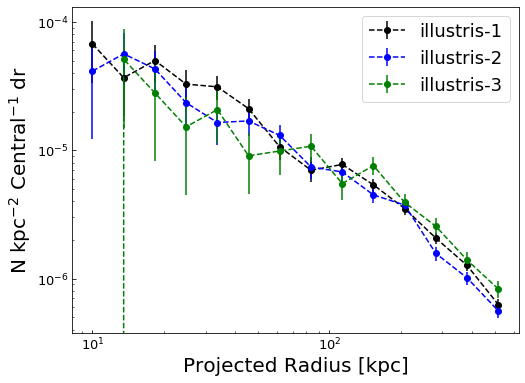

In [27]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

snap = 108
z = 0.4

m_il,s_il=load_subhalo_halo('./sims.illustris/Illustris-1/output',snap,11.15)
radial_tot_il,radial_tot_il_err, count_il = radial(m_il,s_il,z,9.5,13.0)

m_il2,s_il2=load_subhalo_halo('./sims.illustris/Illustris-2/output',snap,11.15)
radial_tot_il2,radial_tot_il2_err, count_il2 = radial(m_il2,s_il2,z,9.5,13.0)

m_il3,s_il3=load_subhalo_halo('./sims.illustris/Illustris-3/output',snap,11.15)
radial_tot_il3,radial_tot_il3_err, count_il3 = radial(m_il3,s_il3,z,9.5,13.0)

plt.errorbar(bin_edges[:-1],radial_tot_il/areas/count_il,yerr=radial_tot_il_err/areas/count_il,fmt='ok--',label='illustris-1')
plt.errorbar(bin_edges[:-1],radial_tot_il2/areas/count_il2,yerr=radial_tot_il2_err/areas/count_il2,fmt='ob--',label='illustris-2')
plt.errorbar(bin_edges[:-1],radial_tot_il3/areas/count_il3,yerr=radial_tot_il3_err/areas/count_il3,fmt='og--',label='illustris-3')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('compare_IL_criteria.png')


massive gals: 102 , isolated centrals: 102
massive gals: 767 , isolated centrals: 767


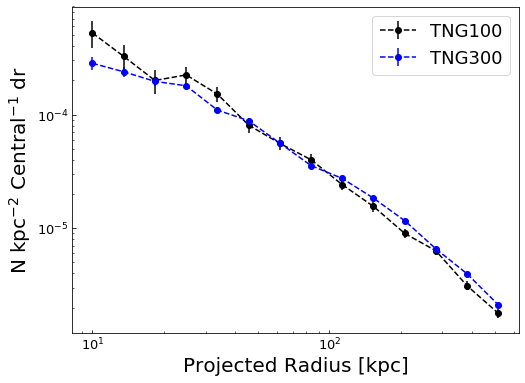

In [28]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

snap = 72
z = 0.4

m_tng,s_tng=load_subhalo_halo('sims.TNG/TNG100-1/output/',snap,11.15)
radial_tot_tng,radial_tot_tng_err, count_tng = radial(m_tng,s_tng,z,9.5,13.0)
m_tng2,s_tng2=load_subhalo_halo('sims.TNG/TNG300-1/output/',snap,11.15)
radial_tot_tng2,radial_tot_tng2_err, count_tng2 = radial(m_tng2,s_tng2,z,9.5,13.0)

plt.errorbar(bin_edges[:-1],radial_tot_tng/areas/count_tng,yerr=radial_tot_tng_err/areas/count_tng,fmt='ok--',label='TNG100')
plt.errorbar(bin_edges[:-1],radial_tot_tng2/areas/count_tng2,yerr=radial_tot_tng2_err/areas/count_tng2,fmt='ob--',label='TNG300')

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=18)
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('compare_IL_TNG_obs_criteria.png')

### three projections

massive gals: 92 , isolated centrals: 92
massive gals: 92 , isolated centrals: 92
massive gals: 92 , isolated centrals: 92


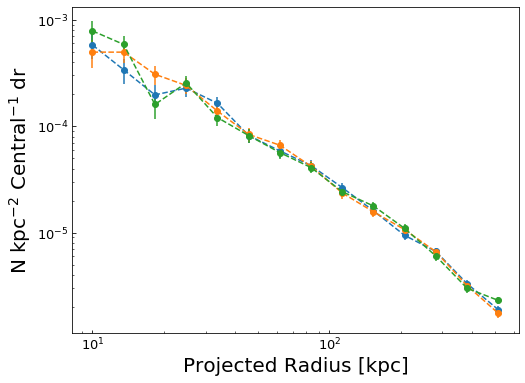

In [12]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

snap = 72
z = 0.4
m_tng,s_tng=load_subhalo_halo('sims.TNG/TNG100-1/output/',snap,11.15)

for proj_collapse in [0,1,2]:
    massive_central_halos, subhalos = load_subhalo_halo('sims.TNG/TNG100-1/output/',snap,11.15)
    radial_tot, radial_tot_err, massive_count = radial(massive_central_halos,subhalos,z, 
                                                             9.5, 13.0, proj_collapse)
    plt.errorbar(bin_edges[:-1],radial_tot/areas/massive_count,
                 yerr=np.sqrt(radial_tot)/areas/massive_count,fmt='o--')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.savefig('three_projection_0.4.png')

massive gals: 92 , isolated centrals: 92
massive gals: 69 , isolated centrals: 69
massive gals: 48 , isolated centrals: 48


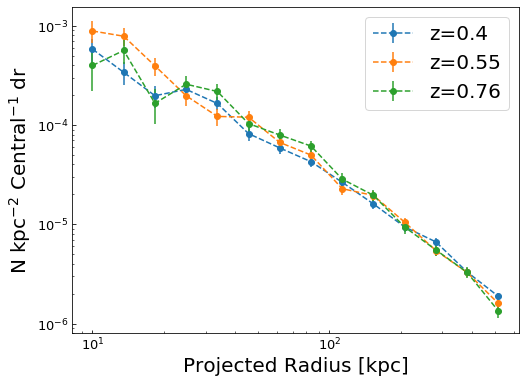

In [6]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))
tng_time = Table.read('TNG_snap_time.csv')
    
for snap in [72, 65, 57]:
    z = tng_time[snap]['z']
    massive_central_halos, subhalos = load_subhalo_halo('sims.TNG/TNG100-1/output/',snap,11.15)
    radial_tot_1, radial_tot_1_err, massive_count_1 = radial(massive_central_halos,subhalos,z, 9.5, 13.0)
    plt.errorbar(bin_edges[:-1],radial_tot_1/areas/massive_count_1,yerr=np.sqrt(radial_tot_1)/areas/massive_count_1,
                 fmt='o--',label='z='+str(z))

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('three_redshifts.png')

### split central/Satellite sfq

1. split by $g-r$ color
2. split by sSFR

In [48]:
massive_central_halos,subhalos = load_subhalo_halo('sims.TNG/TNG100-1/output/',72,11.15)
subhalos = subhalos[subhalos['SubhaloStellarPhotometricsMassInRad']>0.316*0.704]
subhalos['SubhaloSFR'][subhalos['SubhaloSFR']==0.0] = 1e-5

g_r = subhalos['SubhaloStellarPhotometrics'][:,4] - subhalos['SubhaloStellarPhotometrics'][:,5]
mass = np.log10(subhalos['SubhaloStellarPhotometricsMassInRad']/0.704)+10

log_ssfr = np.log10(subhalos['SubhaloSFR']/1e10/0.704/subhalos['SubhaloStellarPhotometricsMassInRad'])

0
8247


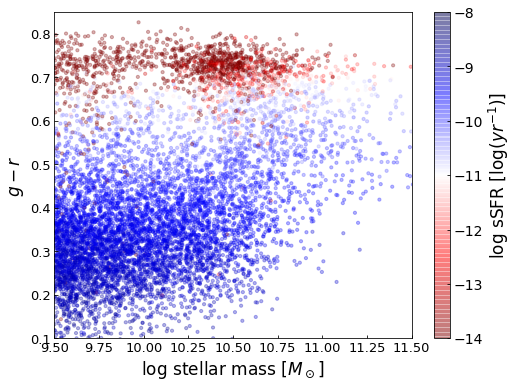

In [51]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))
plt.scatter(mass, g_r,s=10,alpha=0.3,c=log_ssfr,
           vmin=-14, vmax=-8, cmap='seismic_r')

cbar = plt.colorbar() 
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'log sSFR [$\log(yr^{-1})$]',size=17)

plt.xlim([9.5,11.5])
plt.ylim([0.1,0.85])
plt.xlabel(r'log stellar mass [$M_\odot$]',fontsize=17)
plt.ylabel(r'$g-r$',fontsize=17)
plt.show() 

## Trace centrals through redshift
1. list of centrals in SnapNum=N
2. walk back merger tree to SnapNum=N-1
3. find first progenitors (use SubfindID) in SnapNum=N-1
4. repeat to SnapNum = N-2 and so on

In [2]:
basePath = 'sims.TNG/TNG100-1/output/'
last_snap = 99
snap_start = 57

# basePath = './sims.illustris/Illustris-1/output/'
# last_snap = 135
# snap_start = 91

#========================================
header = il.groupcat.loadHeader(basePath,0)
boxsize = header['BoxSize']
track = 'later'

In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as u

bin_number = 20
bin_edges = 10 ** np.linspace(1.0, 3.445, num=bin_number + 1)
areas = np.array([])
for i in range(len(bin_edges[:-1])):
    areas = np.append(areas, (bin_edges[i + 1] ** 2 - bin_edges[i] ** 2) * np.pi)

# load in time,z,snap relation
if 'TNG' in basePath:
    tng_time = Table.read('TNG_snap_time.csv')
    z_list = tng_time['z']
else:
    illustris_time = Table.read('illustris_snap_time.csv')
    z_list = illustris_time['Redshift']

def radial_count(snap, z_list, massive_central_halos, halo_ids,track='prev'):
    z = z_list[snap]
    a = 1/(1+z)
    print('SnapNum',snap,'z =',z)
    
    # load subhalos at snap_start
    fields = ['SubhaloPos','SubhaloMass','SubhaloStellarPhotometricsMassInRad','SubhaloStellarPhotometrics','SubhaloSFR']
    subhalos = il.groupcat.loadSubhalos(basePath,snap,fields=fields)
    del subhalos['count']
    subhalos = Table(subhalos)
    subhalos.add_column(Column(data=np.arange(len(subhalos)),name='id'))
    
    # satellite galaxy mass cut logM=9.5    
    sat_masscut = 10**(9.5-10)
    subhalos_masscut = subhalos[subhalos['SubhaloStellarPhotometricsMassInRad']>sat_masscut*0.704]  # x*10^10 M_sun / h
    tree = KDTree(subhalos_masscut['SubhaloPos'])
    tree_2d = KDTree(subhalos_masscut['SubhaloPos'][:,1:])
    
    radial_tot = np.zeros(bin_number)
    massive_count = 0
    on_edge_count = 0
    total_sat_num = 0
    total_merged = 0
    total_not_in_tree = 0
    halo_ids_checked = [] # checked to have satellites and is a central
    for i in range(len(massive_central_halos)):
        halo = massive_central_halos[i]
        halo_id = halo_ids[i]
        
        # the central galaxy for each halo
        first_subhalo = subhalos[halo['GroupFirstSub']]
        
        # cut central galaxy that is close to box edge
        central_on_edge = False
        for k in range(3):
            if abs(boxsize/2-first_subhalo['SubhaloPos'][k])>boxsize/2-bin_edges[-1]:
                central_on_edge = True
                on_edge_count += 1
        if central_on_edge == True: 
            continue
        
        # exclude halo if its central is more than 10 ckpc/h away from the halo center
        if np.linalg.norm(first_subhalo['SubhaloPos']-halo['GroupPos'])>10: 
            continue
            
        # cut the satellite catalog
        ind = tree_2d.query_radius([halo['GroupPos'][1:]],bin_edges[-1]/a*0.704,count_only=False) # comoving kpc / h
        cat_neighbors = subhalos_masscut[ind[0]]
        cat_neighbors = cat_neighbors[abs(cat_neighbors['SubhaloPos'][:,0]-halo['GroupPos'][0])<bin_edges[-1]*0.704]
        
        # isolation criteria
        cat_bright_neighbors = cat_neighbors[cat_neighbors['SubhaloStellarPhotometricsMassInRad']>first_subhalo['SubhaloStellarPhotometricsMassInRad']]
        if len(cat_bright_neighbors)>=1: 
            print('a more massive companion!','No. of more massive satellites:',len(cat_bright_neighbors))
            continue
        elif len(cat_neighbors)<=1:
            print('no sats!')
            continue
        else:
            halo_ids_checked.append(halo_id)
            
        # remove central from cat_neighbors
        max_mass_index = np.argmax(cat_neighbors['SubhaloStellarPhotometricsMassInRad']) # index of central in catneighbors
        cat_neighbors = np.delete(cat_neighbors, max_mass_index) # remove central from cat_neighbors
        
        # keep record of satellites of this halo and their progenitors/decendants
        if track == 'prev':
            cat_neighbors = sat_prev(halo_id, z, cat_neighbors,snap_start=snap,snap_end=snap-21,halo=halo)
        elif track == 'later':
            cat_neighbors, merged, not_in_tree = sat_later(halo_id, z, cat_neighbors, snap_start=snap,snap_end=snap+21,halo=halo)
            total_sat_num += len(cat_neighbors)
            total_merged += merged
            total_not_in_tree += not_in_tree
        if len(cat_neighbors)==0:
            print('no sats!')
            continue
            
        # calculation (2D selection for radial distribution)
        radial = []        
        subtree = KDTree(cat_neighbors['SubhaloPos'][:,1:])
        for bin_edge in bin_edges:
            ind = subtree.query_radius([halo['GroupPos'][1:]],bin_edge/a*0.704,count_only=True) # comoving kpc / h
            radial.append(ind[0])
        
        radial = np.diff(np.array(radial))
        radial_tot += radial
        massive_count += 1
#         print('No. of sats for '+str(halo_id)+':',len(cat_neighbors))
    
    print('massive gals:',len(massive_central_halos),', isolated centrals:',massive_count,', on edge:',on_edge_count)
    print('Number counts for satellites. Survived:',total_sat_num,'Merged:',total_merged,'Not in tree:',total_not_in_tree)
    return radial_tot, massive_count, halo_ids_checked


# keep track of satellites in previous snapshots
def sat_prev(halo_id, z, cat_neighbors, snap_start, snap_end, halo):
    sat_ids = cat_neighbors['id']
    sat_prev_tot_ids = np.ones(snap_start-snap_end)
    mask = []
    for i, sat_id in enumerate(sat_ids):
        sat_prev = il.sublink.loadTree(basePath,snap_start,sat_id,fields=['SubfindID','SnapNum'],onlyMPB=True)
        if sat_prev != None: # the satellite is in a tree
            sat_prev_ids = sat_prev['SubfindID'][:snap_start-snap_end]
            if sat_prev_tot_ids.shape[-1]==len(sat_prev_ids): # satellite has progenitor up to snap_end
                sat_prev_tot_ids = np.vstack([sat_prev_tot_ids, sat_prev_ids])
                mask.append(True)
            else: 
                mask.append(False)
        else:
            mask.append(False)
    
    cat_neighbors = cat_neighbors[mask]
    cat_neighbors['SubhaloSFR'][cat_neighbors['SubhaloSFR']==0.0] = 1e-5
    cat_logssfr = np.log10(cat_neighbors['SubhaloSFR']/1e10/0.704/cat_neighbors['SubhaloStellarPhotometricsMassInRad'])
    sat_prev_tot_ids = sat_prev_tot_ids[1:]
    
    # record distance list at snap_start
    distance_list(snap_start, z, cat_neighbors, halo['GroupPos'][1:],halo_id, sat_ids, save_dir='sat_catalogs/')
    distance_list_3d(snap_start, z, cat_neighbors, halo['GroupPos'],halo_id, sat_ids, save_dir='sat_catalogs/')
    
    # record id in later snapshots
    np.save('sat_catalogs/'+str(halo_id)+'_logssfr_sats.npy',cat_logssfr)
    np.save('sat_catalogs/'+str(halo_id)+'_sats.npy',sat_prev_tot_ids)
    
    # return cat_neighbors in snap_start
    if len(cat_neighbors)>0:
        return cat_neighbors
    else:
        return np.array([])
    

# keep track of satellites in later snapshots
def sat_later(halo_id, z, cat_neighbors, snap_start, snap_end, halo):
    sat_ids = cat_neighbors['id']
    sat_later_tot_ids = np.array([np.ones(snap_end-snap_start+1)])
    mask = [] 
    merged_list = []
    not_in_tree = 0
    for i, sat_id in enumerate(sat_ids):
        sat_later = il.sublink.loadTree(basePath,snap_start,sat_id,fields=['SubfindID','SnapNum'],onlyMDB=True)
        
        if sat_later != None: # the satellite is in a tree
            if len(sat_later['SubfindID'])!= abs(snap_start-last_snap):  # last_snap=99 for TNG and 135 for il
                mask.append(False)
                merged_list.append(sat_id)
                continue 
                
            sat_later_ids = sat_later['SubfindID'][snap_start-snap_end:]
            if sat_later_tot_ids.shape[-1]==len(sat_later_ids)+1: # satellite has decendant until snap_end
                sat_later_tot_ids = np.vstack([sat_later_tot_ids, np.append(sat_id,np.flip(sat_later_ids,axis=0))])
                mask.append(True)
            else: 
                mask.append(False)
                
        else: # the satellite is NOT in a tree
            mask.append(False)
            not_in_tree += 1
    
    
    cat_neighbors = cat_neighbors[mask]
    cat_neighbors['SubhaloSFR'][cat_neighbors['SubhaloSFR']==0.0] = 1e-5
    cat_logssfr = np.log10(cat_neighbors['SubhaloSFR']/1e10/0.704/cat_neighbors['SubhaloStellarPhotometricsMassInRad'])
    
    # record distance list at snap_start
    distance_list(snap_start, z, cat_neighbors, halo['GroupPos'][1:],halo_id,sat_ids, save_dir='sat_catalogs_later/')
    distance_list_3d(snap_start, z, cat_neighbors, halo['GroupPos'],halo_id,sat_ids, save_dir='sat_catalogs_later/')
#     distance_list_3d_lite(snap=snap_start, z=z, sat_coords=cat_neighbors['SubhaloPos'], central_coord_3d=central_pos)
    
    # record id in later snapshots
    sat_later_tot_ids = sat_later_tot_ids[1:]
    np.save('sat_catalogs_later/'+str(halo_id)+'_merged_sats.npy',merged_list)
    np.save('sat_catalogs_later/'+str(halo_id)+'_logssfr_sats.npy',cat_logssfr)
    np.save('sat_catalogs_later/'+str(halo_id)+'_sats.npy',sat_later_tot_ids)
    
    # return cat_neighbors in snap_start
    return cat_neighbors, len(merged_list), not_in_tree
    

def read_satellite_cat(subhalos, halo_id_start, snap, snap_start, save_dir):
    sat_ids = np.load(save_dir+str(halo_id_start)+'_sats.npy')
    if len(sat_ids.shape)==2:
        sat_ids_this_snap = sat_ids[:,abs(snap_start-snap)]
        sat_ids_snap_start = sat_ids[:,0]
        
        # make sure all satellites are in range(len(subhalos))
#         sat_ids_snap_start = sat_ids_start[sat_ids_this_snap<len(subhalos)]
#         sat_ids_this_snap = sat_ids_this_snap[sat_ids_this_snap<len(subhalos)]
        sat_cat = subhalos[sat_ids_this_snap.astype(int)]
        return sat_cat, sat_ids_snap_start
    
    else:
        print('no satellites for:',halo_id_start)
        return np.array([]), np.array([])
    

def radial_count_prev(snap, z_list, halo_ids_start, halo_ids, halo_ids_start_checked, subhalos):
    z = z_list[snap]
    a = 1/(1+z)
    radial_tot = np.zeros(len(bin_edges)-1)
    
    halo_sat_saved_number = 0
    for i in range(len(halo_ids)):
        halo_id_start = halo_ids_start[i]
        halo_id = halo_ids[i]
        
        # load halo
        save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'
        halo = il.groupcat.loadSingle(basePath,snap,haloID=halo_id)
        
        # check if central galaxy of this halo satisfies all criteria
        if halo_id_start not in halo_ids_start_checked:
            try:
                os.system('rm '+save_dir+'/distance_list_3d_'+str(snap_start)+'_'+str(halo_id_start)+'.npy')
            except FileNotFoundError:
                pass
            
            continue
            
        # read in satellite catalogs in this snapshot
        try:
            sat_cat, sat_ids_start = read_satellite_cat(subhalos, halo_id_start, snap, snap_start, save_dir=save_dir)
            if len(sat_cat)==0: 
                print('no sat for halo '+str(halo_id_start)+' (id at snap_start)')
                continue
            elif len(sat_cat) != len(sat_ids_start):
                print('no. of sat do not match between snaps')
                continue
                
        except FileNotFoundError:
            print(halo_id_start,'not found')
            continue
        
        # save distance list for satellites
        distance_list(snap, z, sat_cat, halo['GroupPos'][1:], halo_id_start, sat_ids_start, save_dir=save_dir)
        distance_list_3d(snap, z, sat_cat, halo['GroupPos'], halo_id_start, sat_ids_start, save_dir=save_dir)
        halo_sat_saved_number += 1
        
        # the calculation
        radial = []
        subtree = KDTree(sat_cat['SubhaloPos'][:,1:])  # ready for 2d spatial selection
        for bin_edge in bin_edges:
            ind = subtree.query_radius([halo['GroupPos'][1:]],bin_edge/a*0.704,count_only=True) # comoving kpc / h
            radial.append(ind[0])
            
        radial = np.diff(np.array(radial))
        radial_tot += radial
    
    print('satellite distance saved for '+ str(halo_sat_saved_number)+' halos.')
    return radial_tot, massive_count


def distance_list(snap, z, cat_sat, central_coord, halo_id, sat_ids_start, save_dir = 'sat_catalogs/'):
    a = 1/(1+z)
    cat_sat_x = cat_sat['SubhaloPos'][:,1]
    cat_sat_y = cat_sat['SubhaloPos'][:,2]
    central_x = central_coord[0]
    central_y = central_coord[1]
    
    distance_list = []
    for i in range(len(cat_sat)):
        dx = abs(cat_sat_x[i]-central_x)
        dy = abs(cat_sat_y[i]-central_y)
        
        if dx > boxsize/2: dx = boxsize - dx
        if dy > boxsize/2: dy = boxsize - dy
        distance = np.sqrt(dx**2+dy**2)*a/0.704
        distance_list.append(distance)
        
    np.save(save_dir+'distance_list_'+str(snap)+'_'+str(halo_id)+'.npy',np.array(distance_list))
    return 0


def distance_list_3d(snap, z, cat_sat, central_coord_3d, halo_id, sat_ids_start, save_dir='sat_catalogs/'):
    a = 1/(1+z)
    cat_sat_x = cat_sat['SubhaloPos'][:,1]
    cat_sat_y = cat_sat['SubhaloPos'][:,2]
    cat_sat_z = cat_sat['SubhaloPos'][:,0]
    central_x = central_coord_3d[1]                       
    central_y = central_coord_3d[2]
    central_z = central_coord_3d[0]
    
    distance_list = []
    sat_ejected_ids = []
    for i in range(len(cat_sat)):
        dx = abs(cat_sat_x[i]-central_x)
        dy = abs(cat_sat_y[i]-central_y)
        dz = abs(cat_sat_z[i]-central_z)
        
        if dx > boxsize/2: dx = boxsize - dx
        if dy > boxsize/2: dy = boxsize - dy
        if dz > boxsize/2: dz = boxsize - dz
        distance = np.sqrt(dx**2+dy**2+dz**2)*a/0.704
        distance_list.append(distance)
        
        if distance>1e4:
            sat_ejected_ids.append(sat_ids_start[i])

    if save_dir[-1]=='/':
        np.save(save_dir+'distance_list_3d_'+str(snap)+'_'+str(halo_id)+'.npy',np.array(distance_list))
        if len(sat_ejected_ids) > 0:
            np.save(save_dir+'ejected_id_list_3d_'+str(snap)+'_'+str(halo_id)+'.npy',np.array(sat_ejected_ids))
    else:
        print('save_dir '+save_dir+' does not end in "/" !')
    return distance_list

def distance_list_3d_lite(snap, z, sat_coords, central_coord_3d):
    a = 1/(1+z)
    cat_sat_x = sat_coords[:,1]
    cat_sat_y = sat_coords[:,2]
    cat_sat_z = sat_coords[:,0]
    central_x = central_coord_3d[1]                       
    central_y = central_coord_3d[2]
    central_z = central_coord_3d[0]
    
    distance_list = []
    for i in range(len(cat_sat_x)):
        dx = abs(cat_sat_x[i]-central_x)
        dy = abs(cat_sat_y[i]-central_y)
        dz = abs(cat_sat_z[i]-central_z)
        
        if dx > boxsize/2: dx = boxsize - dx
        if dy > boxsize/2: dy = boxsize - dy
        if dz > boxsize/2: dz = boxsize - dz
            
        distance = np.sqrt(dx**2+dy**2+dz**2)*a/0.704
#         print(cat_sat_z[i],cat_sat_x[i],cat_sat_y[i])
#         print(central_z,central_x,central_y)
#         print(dz,dx,dy)
#         print(distance)
        distance_list.append(distance)

    return distance_list


In [ ]:
# read in halo and subhalo catalogs ( at snap_start )
print('snap_start:',snap_start)

# load halos (groups) at snap_start
halos_start = il.groupcat.loadHalos(basePath,snap_start,fields=['GroupFirstSub','GroupPos'])
del halos_start['count']
halos_start = Table(halos_start)
halos_start.add_column(Column(data=np.arange(len(halos_start)),name='id'))
# halos_start = halos_start[halos_start['GroupFirstSub']<10000000]

# load subhalos at snap_start
fields = ['SubhaloPos','SubhaloMass','SubhaloStellarPhotometricsMassInRad','SubhaloStellarPhotometrics','SubhaloGrNr']
subhalos_start = il.groupcat.loadSubhalos(basePath,snap_start,fields=fields)
del subhalos_start['count']
subhalos_start = Table(subhalos_start)
subhalos_start.add_column(Column(data=np.arange(len(subhalos_start)),name='id'))

# select halos with massive central galaxies at snap_start
if basePath == './sims.illustris/Illustris-1/output/':
    masscut_central = 12 if track=='prev' else 9
else:
    masscut_central = 14 if track=='prev' else 10
    
first_subhalos_start = subhalos_start[halos_start['GroupFirstSub']]
massive_central_halos_start = halos_start[first_subhalos_start['SubhaloStellarPhotometricsMassInRad']>masscut_central*0.704]

# save the central/halo ids
central_ids_start = massive_central_halos_start['GroupFirstSub']
halo_ids_start = np.array(subhalos_start['SubhaloGrNr'][central_ids_start])

print(len(massive_central_halos_start),len(halo_ids_start))
print(len(central_ids_start))
# print(halos_start[0]['id'])

snap_start: 57


Find progenitors/decendants

In [69]:
# list of centrals and their ID in previous snapshots 
# progenitors
print('snap_start:',snap_start)
merger_tree = il.sublink.loadTree(basePath,snap_start,central_ids_start[0],
                                  fields=['SubfindID','FirstProgenitorID'],onlyMPB=True)

progenitors = merger_tree['SubfindID'][:20]
for central_id in central_ids_start[1:]:
    merger_tree = il.sublink.loadTree(basePath,snap_start,central_id,fields=['SubfindID','FirstProgenitorID'],onlyMPB=True)
    if merger_tree != None:
        
        # if the galaxy has progenitor for at least 20 previous snapshots
        if len(merger_tree['SubfindID'])>20:
            progenitors=np.vstack([progenitors,merger_tree['SubfindID'][:20]])

print(progenitors.shape)


snap_start: 57
(108, 20)


In [115]:
# list of centrals and their ID in later snapshots
# decendants

print('snap_start:',snap_start)
decendants = np.ones(21)
mask = []

for i,central_id in enumerate(central_ids_start):
    merger_tree = il.sublink.loadTree(basePath,snap_start,central_id,fields=['SnapNum','SubfindID'],onlyMDB=True)
    if merger_tree != None:   
        # cut off centrals that don't have right length of MDB.
        if len(merger_tree['SubfindID'])>20 and merger_tree['SnapNum'][-20]-merger_tree['SnapNum'][-1]==19:
            decendants = np.vstack([decendants, np.append(central_id, np.flip(merger_tree['SubfindID'][-20:],axis=0))])
            mask.append(True)
        else:
            mask.append(False)
    else:
        print('merger tree is None.')

decendants = decendants[1:].astype(int)
central_ids_start = central_ids_start[mask].astype(int
halo_ids_start = halo_ids_start[mask].astype(int)

print(decendants.shape)

snap_start: 57
(105, 21)


In [71]:
# basePath = 'sims.TNG/TNG100-1/output/'
# merger_tree = il.sublink.loadTree(basePath,55,1303,fields=['SnapNum','SubfindID'],onlyMDB=True)

# snaps = merger_tree['SnapNum']
# ids = merger_tree['SubfindID']

# for i,snap in enumerate(snaps):
#     fields = ['SubhaloGrNr','SubhaloPos']
#     subhalos = il.groupcat.loadSubhalos(basePath,snap,fields=fields)
#     del subhalos['count']
#     subhalos = Table(subhalos)
    
#     print(subhalos[ids[i]]['SubhaloPos'])


calculate radial number density

In [116]:
# calculate radial number density
# tracing both centrals and satellites between snapshots

radial_z = np.zeros(bin_number)
massive_counts = []
if track =='prev':
    snaps = np.arange(snap_start,snap_start-19,-5)
else:
    snaps = np.arange(snap_start,snap_start+19,5)
    
print(track,snaps)

for snap in snaps:
    print('===SnapNum:',snap)
    
    # load halos at this snap
    halos = il.groupcat.loadHalos(basePath,snap,fields=['GroupFirstSub','GroupPos'])
    del halos['count']
    halos = Table(halos)
    
    # load subhalos at this snap
    fields = ['SubhaloGrNr','SubhaloPos']
    subhalos = il.groupcat.loadSubhalos(basePath,snap,fields=fields)
    del subhalos['count']
    subhalos = Table(subhalos)
    
    # find the progenitors/decendants of centrals and the halos they live in (selected in snap_start)
    # IDs in current snapshot
    if track =='prev':
        central_ids = progenitors[:, snap_start - snap]
    else:
        central_ids = decendants[:, snap - snap_start]
            
    halo_ids = np.array(subhalos[central_ids]['SubhaloGrNr'])
    massive_central_halos = halos[halo_ids]
    
    print('central number:',len(massive_central_halos))

#   calculate number density profile
    if snap == snap_start:
        radial_tot_z, massive_count,halo_ids_start_checked = radial_count(snap, z_list, massive_central_halos,halo_ids_start,track=track)
    else:
        radial_tot_z, massive_count = radial_count_prev(snap,z_list, halo_ids_start, halo_ids, halo_ids_start_checked, subhalos)
    
    # stack results for each snapshot 
    radial_z = np.vstack([radial_z,radial_tot_z])
    massive_counts.append(massive_count)

# radial_z is collection of the radial distribution at all snaps
radial_z = radial_z[1:]

later [57 62 67 72]
===SnapNum: 57
central number: 105
SnapNum 57 z = 0.76
1 [ 10775.20019531  51337.66796875  47409.1953125 ] halo_pos
1 [ 10775.20019531  51337.66796875  47409.1953125 ]
Warning, empty return. Subhalo [6922] at snapNum [57] not in tree.
2 [ 43591.65234375  38391.5859375   70788.8828125 ] halo_pos
2 [ 43591.65234375  38391.5859375   70788.8828125 ]
Warning, empty return. Subhalo [11592] at snapNum [57] not in tree.
Warning, empty return. Subhalo [11603] at snapNum [57] not in tree.
Warning, empty return. Subhalo [11587] at snapNum [57] not in tree.
3 [ 24911.99023438  30905.86132812  40869.109375  ] halo_pos
3 [ 24911.99023438  30905.86132812  40869.109375  ]
Warning, empty return. Subhalo [15980] at snapNum [57] not in tree.
Warning, empty return. Subhalo [15985] at snapNum [57] not in tree.
4 [ 67530.8984375   59171.94140625  53389.77734375] halo_pos
4 [ 67530.8984375   59171.94140625  53389.77734375]
7 [ 18659.36523438  68808.75         3136.37841797] halo_pos
7 [ 1

In [73]:
# the missing satellite galaxies: are they merged?
# only work for track == 'later'

# id's at snap_start
for halo_id in halo_ids_start:
    central_id = halos_start[halo_id]['GroupFirstSub']
    try:
        merged_sat_ids = np.load('sat_catalogs_later/'+str(halo_id)+'_merged_sats.npy')
    except FileNotFoundError:
        continue

    # look into central galaxies' merger tree
    if central_id in decendants[:,0]:
        descendant_id = decendants[decendants[:,0]==central_id][0][-1]
        full_tree = il.sublink.loadTree(basePath,snap_start+decendants.shape[1]-1,descendant_id,
                                fields=['SnapNum','SubfindID','FirstProgenitorID'])

        subfind_IDs = full_tree['SubfindID']
        merged = 0
        for sat_id in merged_sat_ids:
            if sat_id in subfind_IDs:
                merged += 1
        print(halo_id,'No. of galaxies merged:',len(merged_sat_ids),', merged with central:',merged)

0 No. of galaxies merged: 10 , merged with central: 10
1 No. of galaxies merged: 12 , merged with central: 11
2 No. of galaxies merged: 7 , merged with central: 6
3 No. of galaxies merged: 6 , merged with central: 4
4 No. of galaxies merged: 5 , merged with central: 3
7 No. of galaxies merged: 4 , merged with central: 2
8 No. of galaxies merged: 7 , merged with central: 3
9 No. of galaxies merged: 9 , merged with central: 6
10 No. of galaxies merged: 3 , merged with central: 2
12 No. of galaxies merged: 8 , merged with central: 0
13 No. of galaxies merged: 3 , merged with central: 2
15 No. of galaxies merged: 1 , merged with central: 0
16 No. of galaxies merged: 12 , merged with central: 10
17 No. of galaxies merged: 7 , merged with central: 0
19 No. of galaxies merged: 10 , merged with central: 1
20 No. of galaxies merged: 10 , merged with central: 4
21 No. of galaxies merged: 8 , merged with central: 1
22 No. of galaxies merged: 7 , merged with central: 1
23 No. of galaxies merged: 5

In [101]:
halos_start[6]['GroupPos']
halos_start[7]['GroupPos']

array([ 18659.36523438,  68808.75      ,   3136.37841797], dtype=float32)

5 central [ 57820.46484375  74891.859375    37448.23828125]
sats [ 44052.01953125  38242.3828125   70979.5546875 ]
41602.4493459
7 central [ 18659.36523438  68808.75         3136.37841797]
sats [ 17228.7421875   67270.5625       1243.78820801]
2281.98646468
8 central [ 22080.3125      49491.46484375  48705.0703125 ]
sats [ 21331.20507812  46451.02734375  48149.88671875]
2566.66183753
9 central [ 54489.421875     9000.26855469  34715.26171875]
sats [ 56281.48046875  11035.4375      32452.90625   ]
2850.20722816
10 central [ 25413.90625     36565.94921875  43689.9375    ]
sats [ 25096.58007812  36326.203125    41277.39453125]
1973.38652279
57


(0, 2786.1211686297693)

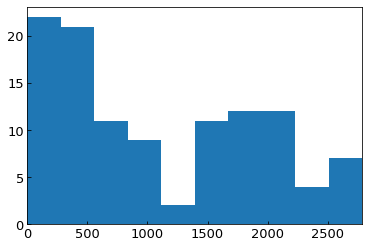

In [125]:
# distance distribution of merged galaxies

# id's at snap_start
distances_sat_list = np.array([])
for halo_id in halo_ids_start[5:10]:
    central_id = halos_start[halo_id]['GroupFirstSub']
    try:
        merged_sat_ids = np.load('sat_catalogs_later/'+str(halo_id)+'_sats.npy')
        merged_sat_ids = merged_sat_ids[:,0]
        merged_sat_ids = merged_sat_ids.astype(int)
#         print(merged_sat_ids)
    except FileNotFoundError:
        continue
    
    central_pos = subhalos_start[central_id]['SubhaloPos']
    sats_pos = subhalos_start[merged_sat_ids]['SubhaloPos']
    
    print(halo_id,'central',central_pos)
    print('sats',sats_pos[0])

    distances =  distance_list_3d_lite(snap=snap_start, z=0.76, sat_coords=sats_pos, central_coord_3d=central_pos)
    distances_sat_list = np.hstack([distances_sat_list,distances])
    print(distances[0])

print(snap_start)
plt.hist(distances_sat_list,range=(0,10**3.445))
plt.xlim([0,10**3.445])

### Distribution evolution plot

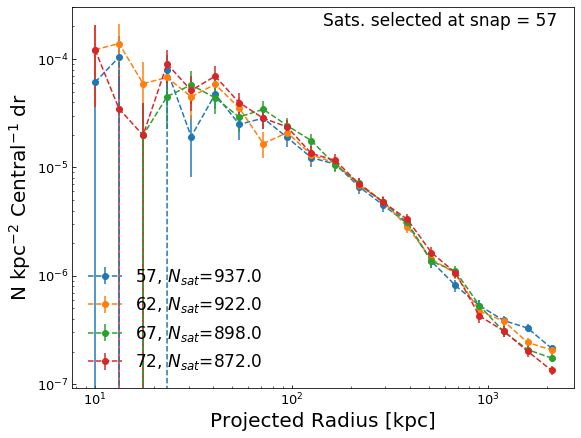

In [85]:
# make the plot

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(9, 7))

for i in range(len(radial_z)):
    plt.errorbar(bin_edges[:-1],radial_z[i]/areas/massive_counts[i],yerr=np.sqrt(radial_z[i])/areas/massive_counts[i],
             fmt='o--',label=str(snaps[i])+', $N_{sat}$='+str(sum(radial_z[i])))

plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.5,0.95),xycoords='axes fraction',fontsize=17)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=17,frameon=False,loc='lower left')
plt.savefig('trace_distribution_'+str(snap_start)+'.png')


106 0 10 0
229 0 2 0
359 16 16 7
total 72, sat number matched 69, not matched 3
snap_start: 57


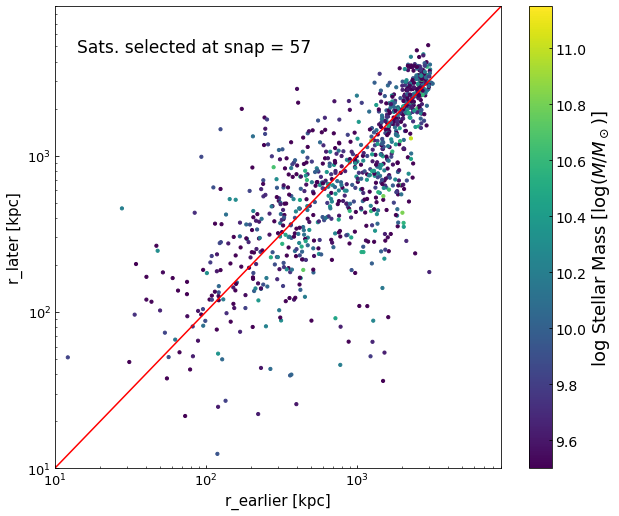

In [88]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8.5))
fields = ['SubhaloPos','SubhaloMass','SubhaloStellarPhotometricsMassInRad']

subhalos = il.groupcat.loadSubhalos(basePath,snap_start,fields=fields)
del subhalos['count']
subhalos = Table(subhalos)

save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'
match= 0
no_match = 0
for halo_id_start in halo_ids_start:
    try:
        r57 = np.load(save_dir+'distance_list_3d_'+str(min(snaps))+'_'+str(halo_id_start)+'.npy')
        r72 = np.load(save_dir+'distance_list_3d_'+str(max(snaps))+'_'+str(halo_id_start)+'.npy')
        logssfr_start = np.load(save_dir+str(halo_id_start)+'_logssfr_sats.npy')
    except FileNotFoundError:
        continue
    
    sat_ids = np.load(save_dir+str(halo_id_start)+'_sats.npy')
    sat_ids_start = sat_ids[:,0]
    sat_cat = subhalos[sat_ids_start.astype(int)]
    subhalo_masses = sat_cat['SubhaloMass']
    stellar_masses = sat_cat['SubhaloStellarPhotometricsMassInRad']
    
    if len(r57) == len(r72) and len(r57) == len(stellar_masses):
        plt.scatter(r57,r72,c=np.log10(stellar_masses*0.7)+10,s=10,vmin=9.5, vmax=11.15)
#         plt.scatter(r57,r72,c=logssfr_start,s=10,vmin=-14, vmax=-8,cmap='jet_r')
        match += 1
    else:
        print(halo_id_start,len(r57),len(r72),len(stellar_masses))
        no_match += 1

print('total '+str(match+no_match)+', sat number matched '+str(match)+', not matched '+str(no_match))
plt.plot([0,1e4],[0,1e4],'r')
plt.xlim([10,9000])
plt.ylim([10,9000])
plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar() 
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'log Stellar Mass [$\log(M/M_\odot)$]',size=18)
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.9),xycoords='axes fraction',fontsize=17)

plt.xlabel('r_earlier [kpc]', fontsize=15)
plt.ylabel('r_later [kpc]', fontsize=15)
plt.savefig('distance_change_two_snap_'+str(snap_start)+'.png',dpi=150)
print('snap_start:',snap_start) 

satellites within 10.0 to 13.2510410693: 0
satellites within 13.2510410693 to 17.559008942: 1
satellites within 17.559008942 to 23.2675148626: 1
satellites within 23.2675148626 to 30.8318795025: 1
satellites within 30.8318795025 to 40.8554501531: 2
satellites within 40.8554501531 to 54.1377247883: 7
satellites within 54.1377247883 to 71.7381214567: 13
satellites within 71.7381214567 to 95.0604793656: 19
satellites within 95.0604793656 to 125.965031614: 31
satellites within 125.965031614 to 166.916780721: 61
satellites within 166.916780721 to 221.182111649: 83
satellites within 221.182111649 to 293.089324525: 119
satellites within 293.089324525 to 388.373867625: 159
satellites within 388.373867625 to 514.635807014: 229
satellites within 514.635807014 to 681.946021446: 301
satellites within 681.946021446 to 903.649473722: 364


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


snap_start: 57


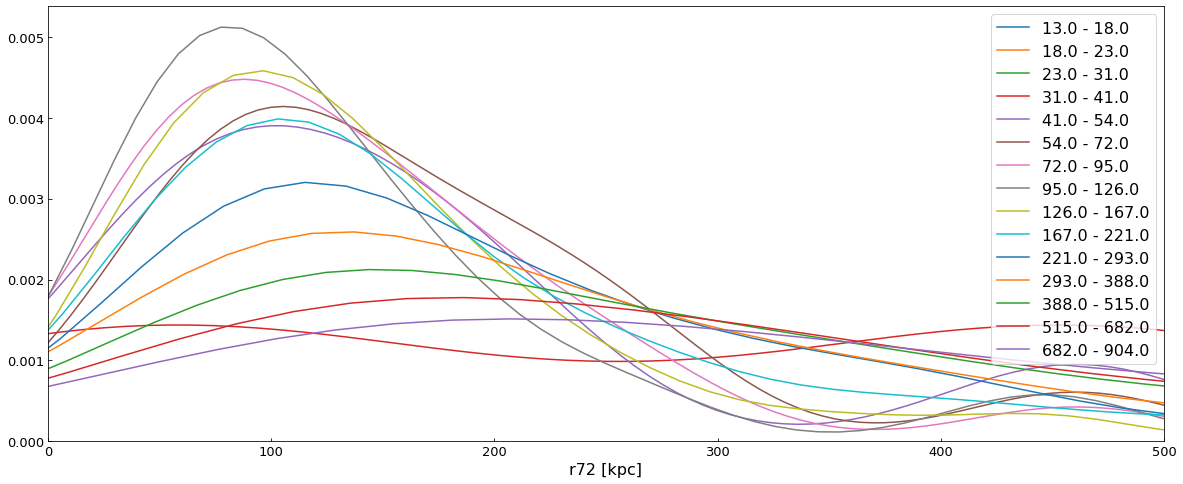

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
fields = ['SubhaloPos','SubhaloMass','SubhaloStellarPhotometricsMassInRad']

subhalos = il.groupcat.loadSubhalos(basePath,snap_start,fields=fields)
del subhalos['count']
subhalos = Table(subhalos)

save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'
match= 0
no_match = 0
r57_list = np.array([])
r72_list = np.array([])
for halo_id_start in halo_ids_start:
    try:
        r57 = np.load(save_dir+'distance_list_3d_'+str(min(snaps))+'_'+str(halo_id_start)+'.npy')
        r72 = np.load(save_dir+'distance_list_3d_'+str(max(snaps))+'_'+str(halo_id_start)+'.npy')
    except FileNotFoundError:
        continue
    
    if len(r57) == len(r72):
        r57_list = np.append(r57_list,r57)
        r72_list = np.append(r72_list,r72)

sns.set_palette(sns.color_palette("hls", len(bin_edges[:-5])))
for i in range(len(bin_edges[:-5])):
    areas = np.append(areas, (bin_edges[i + 1] ** 2 - bin_edges[i] ** 2) * np.pi)
    r72_cut = r72_list[np.logical_and(r57_list<bin_edges[i + 1],r57_list<bin_edges[i])]
    print('satellites within '+str(bin_edges[i])+' to '+str(bin_edges[i+1])+':',len(r72_cut))
    sns.kdeplot(r72_cut,label=str(round(bin_edges[i]))+' - '+str(round(bin_edges[i+1])))

plt.legend(fontsize=16,loc='upper right')
plt.xlim([0,500])
plt.xlabel('r72 [kpc]', fontsize=16)
plt.savefig('distance_change_histogram_'+str(snap_start)+'.png',dpi=150)
print('snap_start:',snap_start)

### test dynamical friction and stripping

NameError: name 'distance_3d' is not defined

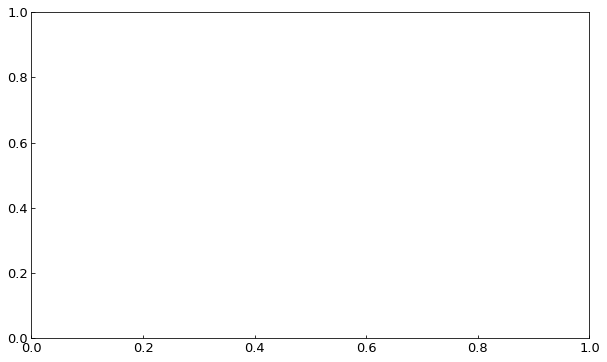

In [13]:
# dr/dt vs r plot

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
sat_ids = np.load('sat_catalogs_later/'+str(halo_id)+'_merged_sats.npy')
for i, sat_id in enumerate(sat_ids):
    distances_sat = distance_3d()
    for snap in np.arange(57,72,1):
        dr = distance_sat[snap] - distance_sat[snap-1]
        dt = time_tng[snap] - time_tng[snap]
        drdt = dr/dt
        r = distance_sat[snap]

plt.plot(r,drdt)
plt.savefig('dr_dt_'+str(snap_start)+'.png',dpi=150)
print('snap_start:',snap_start)

In [ ]:
# dM/dt vs r plot

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
for snap in np.arange(57,72,1):
    dr=
    dt=
    drdt = dr/dt
    r = 

plt.plot()
plt.savefig('dr_dt_'+str(snap_start)+'.png',dpi=150)
print('snap_start:',snap_start)

### migration of satellites

In [76]:
save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'
print('track:',track)
print('save_dir:',save_dir)
print('snap_start:',snap_start)

r57_list = np.array([])
r72_list = np.array([])
mass_list = np.array([])
logssfr_list = np.array([])
for halo_id_start in halo_ids_start:
    try:
        r57 = np.load(save_dir+'distance_list_3d_'+str(min(snaps))+'_'+str(halo_id_start)+'.npy')
        r72 = np.load(save_dir+'distance_list_3d_'+str(max(snaps))+'_'+str(halo_id_start)+'.npy')
        logssfr_start = np.load(save_dir+str(halo_id_start)+'_logssfr_sats.npy')
    except FileNotFoundError:
        continue
    
    # get stellar masses and subhalo masses 
    sat_ids = np.load(save_dir+str(halo_id_start)+'_sats.npy')
    sat_ids_start = sat_ids[:,0] # 0 --> snap_start
    sat_cat = subhalos_start[sat_ids_start.astype(int)]
        
    subhalo_masses = sat_cat['SubhaloMass']  # subhalo mass at snap_start
    stellar_masses = sat_cat['SubhaloStellarPhotometricsMassInRad'] # stellar mass at snap_start
    
    # gather information
    if len(r57) == len(r72) and len(r57) == len(stellar_masses):
        r57_list = np.append(r57_list,r57)
        r72_list = np.append(r72_list,r72)
        mass_list = np.append(mass_list,np.log10(stellar_masses*0.714)+10)
        logssfr_list = np.append(logssfr_list,logssfr_start)
    else:
        continue

print(len(r57_list))
print(len(r72_list))

track: later
save_dir: sat_catalogs_later/
snap_start: 91
1263
1263


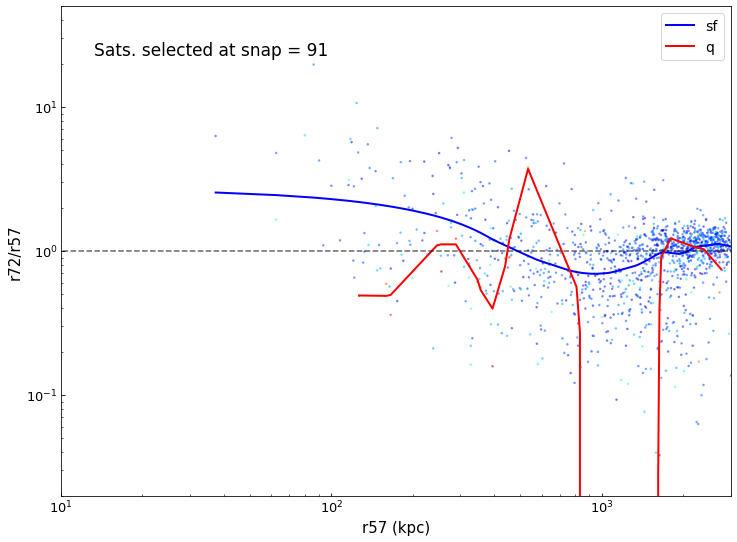

In [78]:
# plotting (split by ssfr)
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(12, 9))

# cut sample (ssfr)
ssfrcut = -11
r72_sf = r72_list[logssfr_list>ssfrcut]
r57_sf = r57_list[logssfr_list>ssfrcut]
r72_q = r72_list[logssfr_list<ssfrcut]
r57_q = r57_list[logssfr_list<ssfrcut]

# plot data
plt.scatter(r57_list,r72_list/r57_list,marker='.',c=logssfr_list,s=10,alpha=0.4,cmap='jet_r')

# plot fitting
nonpar_fit=lowess(r72_sf/r57_sf, r57_sf,frac=0.2)
plt.plot(nonpar_fit[:,0],nonpar_fit[:,1],'b',linewidth=2,label='sf')
nonpar_fit=lowess(r72_q/r57_q, r57_q,frac=0.2)
plt.plot(nonpar_fit[:,0],nonpar_fit[:,1],'r',linewidth=2,label='q')

plt.plot([0,10000],[1,1],'--k',alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10,3000])
plt.ylim([0.02,50])
plt.legend(fontsize=14) 
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.9),xycoords='axes fraction',fontsize=17)

plt.xlabel('r57 (kpc)', fontsize=15)
plt.ylabel('r72/r57', fontsize=15)
plt.savefig('distance_ratio_change_two_snap_'+str(snap_start)+'.png',dpi=150)


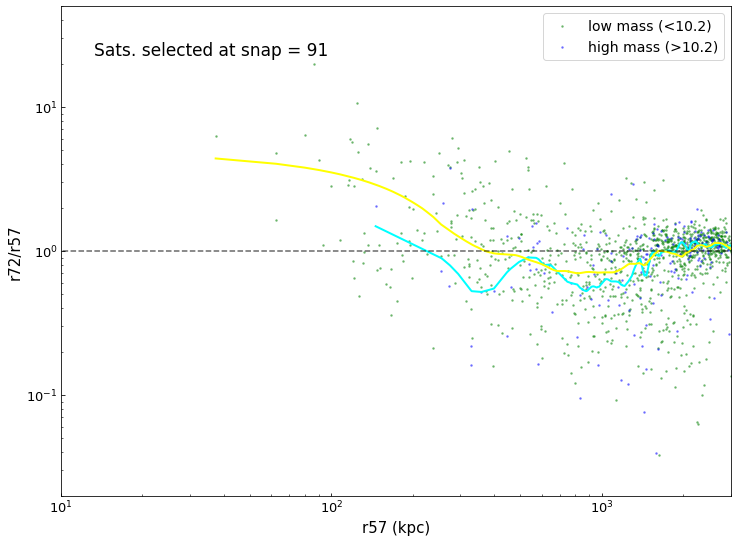

In [80]:
# plotting (mass dependence)

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(12, 9))

# cut sample (high/low mass)
masscut = 10.2
r72_high_mass = r72_list[mass_list>masscut]
r57_high_mass = r57_list[mass_list>masscut]
r72_low_mass = r72_list[mass_list<masscut]
r57_low_mass = r57_list[mass_list<masscut]

# plot
plt.scatter(r57_low_mass,r72_low_mass/r57_low_mass,marker='.',c='g',s=10,alpha=0.4,label='low mass (<'+str(masscut)+')')
plt.scatter(r57_high_mass,r72_high_mass/r57_high_mass,marker='.',c='b',s=10,alpha=0.4,label='high mass (>'+str(masscut)+')')

nonpar_fit=lowess(r72_high_mass/r57_high_mass, r57_high_mass,frac=0.1)
plt.plot(nonpar_fit[:,0],nonpar_fit[:,1],'cyan',linewidth=2)
nonpar_fit=lowess(r72_low_mass/r57_low_mass, r57_low_mass,frac=0.1)
plt.plot(nonpar_fit[:,0],nonpar_fit[:,1],'yellow',linewidth=2)

plt.plot([0,10000],[1,1],'--k',alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10,3000])
plt.ylim([0.02,50])
plt.legend(fontsize=14) 
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.9),xycoords='axes fraction',fontsize=17)

# x = np.linspace(10,6000,100)
# plt.plot(x,np.sqrt(3)*100000*0.704/x/2,'--k',alpha=0.5)

plt.xlabel('r57 (kpc)', fontsize=15)
plt.ylabel('r72/r57', fontsize=15)
plt.savefig('distance_ratio_change_two_snap_'+str(snap_start)+'.png',dpi=150)

### mass change of satellite galaxies

In [12]:
fields = ['SubhaloPos','SubhaloMass','SubhaloStellarPhotometricsMassInRad']
save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'

subhalos = il.groupcat.loadSubhalos(basePath,72,fields=fields)
del subhalos['count']
subhalos = Table(subhalos)

m72_stellar = []
m57_stellar = []
m72_subhalo = []
m57_subhalo = []
logssfr_list = []
if track == 'prev':
    halos_start = np.copy(halo_ids_start)
else:
    halos_start = np.copy(halo_ids_start_checked)
    
for halo_id_start in halos_start:
    sat_ids = np.load(save_dir+str(halo_id_start)+'_sats.npy')
    sat_ids_start = sat_ids[:,0]
    logssfr_start = np.load(save_dir+str(halo_id_start)+'_logssfr_sats.npy')
    sat_cat = subhalos_start[sat_ids_start.astype(int)]
    
    for i,sat_id_start in enumerate(sat_ids_start):
        logssfr_list.append(logssfr_start[i])
        if track=='prev':
            tree = il.sublink.loadTree(basePath,snap_start,sat_id_start,
                               fields=['SnapNum','SubfindID','SubhaloMass','SubhaloStellarPhotometricsMassInRad'],
                               onlyMPB=True)
            
            m72_subhalo.append(tree['SubhaloMass'][0])
            m57_subhalo.append(tree['SubhaloMass'][snap_end-snap_start])
            m72_stellar.append(tree['SubhaloStellarPhotometricsMassInRad'][0])
            m57_stellar.append(tree['SubhaloStellarPhotometricsMassInRad'][snap_end-snap_start])
                
        else:
            snap_end =snaps[-1] #72
            tree = il.sublink.loadTree(basePath,snap_start,sat_id_start,
                               fields=['SnapNum','SubfindID','SubhaloMass','SubhaloStellarPhotometricsMassInRad'],
                               onlyMDB=True)
            
            m72_subhalo.append(tree['SubhaloMass'][-(snap_end-snap_start)])
            m57_subhalo.append(subhalos_start[int(sat_id_start)]['SubhaloMass'])
            m72_stellar.append(tree['SubhaloStellarPhotometricsMassInRad'][-(snap_end-snap_start)])
            m57_stellar.append(subhalos_start[int(sat_id_start)]['SubhaloStellarPhotometricsMassInRad'])   

m72_stellar = np.array(m72_stellar)
m57_stellar = np.array(m72_stellar)
m72_subhalo = np.array(m72_subhalo)
m57_subhalo = np.array(m72_subhalo)     

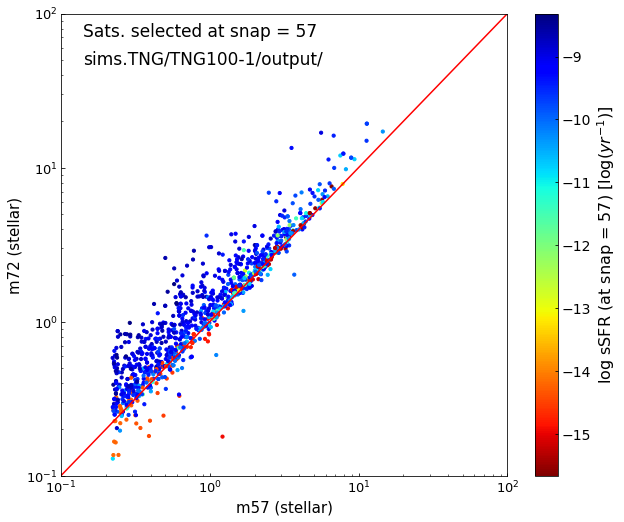

In [61]:
# stellar mass change of satellites

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 8.5))
plt.scatter(m57_stellar,m72_stellar,c=np.array(logssfr_list),s=10,cmap='jet_r')

plt.plot([0.1,1e2],[0.1,1e2],'r')
plt.xlim([0.1,1e2])
plt.ylim([0.1,1e2])
plt.xscale('log')
plt.yscale('log')
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.95),xycoords='axes fraction',fontsize=17)
plt.annotate(basePath,xy=(0.05,0.89),xycoords='axes fraction',fontsize=17)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'log sSFR (at snap = '+str(snap_start)+') [$\log(yr^{-1})$]',size=16)

plt.xlabel('m57 (stellar)', fontsize=15)
plt.ylabel('m72 (stellar)', fontsize=15)
plt.savefig('mass_change_two_snap_'+str(snap_start)+'.png')

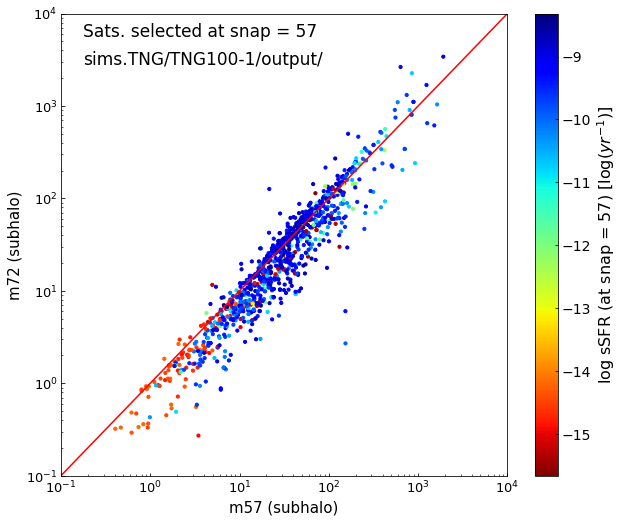

In [24]:
# subhalo mass change of satellites

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 8.5))

plt.scatter(m57_subhalo,m72_subhalo,c=np.array(logssfr_list),s=10,cmap='jet_r')

plt.plot([0.1,1e4],[0.1,1e4],'r')
plt.xlim([0.1,1e4])
plt.ylim([0.1,1e4])
plt.xscale('log')
plt.yscale('log')
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.95),xycoords='axes fraction',fontsize=17)
plt.annotate(basePath,xy=(0.05,0.89),xycoords='axes fraction',fontsize=17)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'log sSFR (at snap = '+str(snap_start)+') [$\log(yr^{-1})$]',size=16)

plt.xlabel('m57 [] (subhalo)', fontsize=15)
plt.ylabel('m72 [] (subhalo)', fontsize=15)
plt.savefig('mass_subhalo_change_two_snap_'+str(snap_start)+'.png')

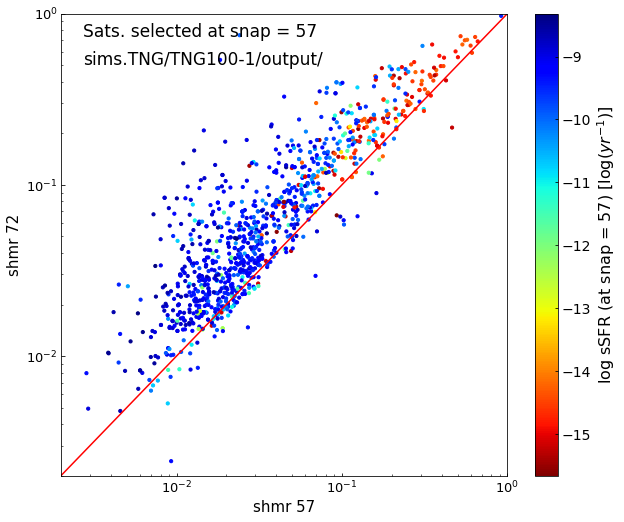

In [25]:
# shmr change of satellites

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 8.5))

plt.scatter(np.array(m57_stellar)/np.array(m57_subhalo),np.array(m72_stellar)/np.array(m72_subhalo)
            ,c=np.array(logssfr_list),s=10,cmap='jet_r')

plt.plot([0.002,1],[0.002,1],'r')
plt.xlim([0.002,1])
plt.ylim([0.002,1])
plt.xscale('log')
plt.yscale('log')
plt.annotate('Sats. selected at snap = '+str(snap_start),xy=(0.05,0.95),xycoords='axes fraction',fontsize=17)
plt.annotate(basePath,xy=(0.05,0.89),xycoords='axes fraction',fontsize=17)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'log sSFR (at snap = '+str(snap_start)+') [$\log(yr^{-1})$]',size=16)

plt.xlabel('shmr 57', fontsize=15)
plt.ylabel('shmr 72', fontsize=15)
plt.savefig('shmr_change_two_snap_'+str(snap_start)+'.png')


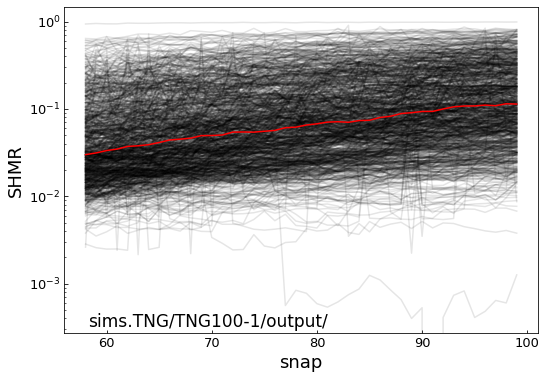

In [28]:
# shmr change as a function of redshift

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8.5, 6))

save_dir = 'sat_catalogs/' if track=='prev' else 'sat_catalogs_later/'
if track == 'prev':
    halos_start = np.copy(halo_ids_start)
    tree_length = snap_start+1
    onlymdb = False
    onlympb = True
else:
    halos_start = np.copy(halo_ids_start_checked)
    tree_length = 99 - snap_start 
    onlymdb = True
    onlympb = False

m_subhalo = np.array(np.ones(tree_length))
m_stellar = np.array(np.ones(tree_length))
for halo_id_start in halos_start:
    sat_ids = np.load(save_dir+str(halo_id_start)+'_sats.npy')
    sat_ids_start = sat_ids[:,0]
    sat_cat = subhalos[sat_ids_start.astype(int)]
    
    for sat_id in sat_ids_start:
        tree = il.sublink.loadTree(basePath,snap_start,sat_id,
                               fields=['SnapNum','SubfindID','SubhaloMass','SubhaloStellarPhotometricsMassInRad'],
                               onlyMDB=onlymdb,onlyMPB=onlympb)
        if tree == None:  
            continue
        
        if len(tree['SubhaloMass'])==tree_length:
            snaps = tree['SnapNum'][:tree_length]
            m_subhalo = np.vstack([m_subhalo,  np.array(tree['SubhaloMass'][:tree_length])])
            m_stellar = np.vstack([m_stellar, np.array(tree['SubhaloStellarPhotometricsMassInRad'][:tree_length])])
        
            plt.plot(tree['SnapNum'][:tree_length],
                     tree['SubhaloStellarPhotometricsMassInRad'][:tree_length]/tree['SubhaloMass'][:tree_length],
                     'k',alpha=0.1)
    
m_subhalo = np.array(m_subhalo)
m_stellar = np.array(m_stellar)
plt.plot(snaps,np.median(m_stellar,axis=0)/np.median(m_subhalo,axis=0),'r')
plt.annotate(basePath,xy=(0.05,0.02),xycoords='axes fraction',fontsize=17)

plt.xlabel('snap',fontsize=18)
plt.ylabel('SHMR',fontsize=18)
plt.yscale('log')
plt.savefig('shmr_change_snaps_'+str(snap_start)+'.png')


1032 1032


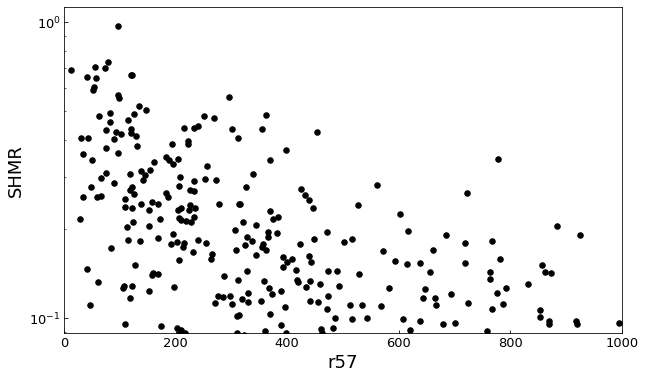

In [13]:
# SHMR vs. r plot

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 6))
m57_stellar = np.array(m72_stellar)
m57_subhalo = np.array(m72_subhalo) 
plt.scatter(r57_list,m57_stellar/m57_subhalo,c='k',s=30)

print(len(r57_list),len(m57_stellar))
plt.xlim([0,1000])
plt.xlabel('r57',fontsize=18)
plt.ylabel('SHMR',fontsize=18)
plt.yscale('log')
plt.savefig('shmr_change_snaps_'+str(snap_start)+'.png')

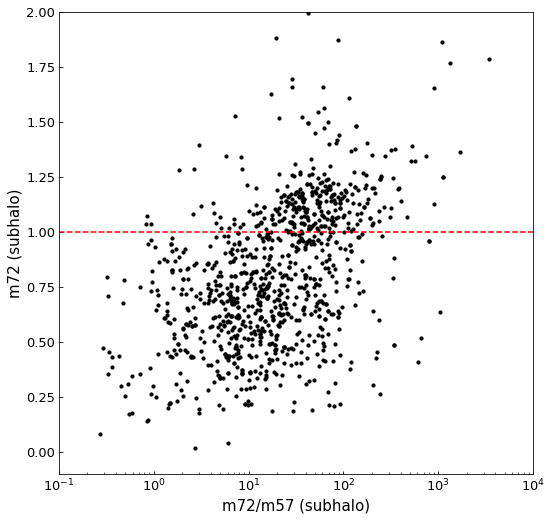

In [20]:
# subhalo mass change of satellites

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8.5, 8.5))

plt.scatter(m72_subhalo,np.array(m72_subhalo)/np.array(m57_subhalo),c='k',s=10)

plt.plot([0.1,1e4],[1,1],'--r')
plt.xlim([0.1,1e4])
plt.ylim([-0.1,2])
plt.xscale('log')
# plt.yscale('log')

plt.xlabel('m72/m57 (subhalo)', fontsize=15)
plt.ylabel('m72 (subhalo)', fontsize=15)
plt.savefig('mass_subhalo_ratio_change_two_snap.png')

### mass growth of central galaxies

ValueError: x and y must have same first dimension, but have shapes (50,) and (42,)

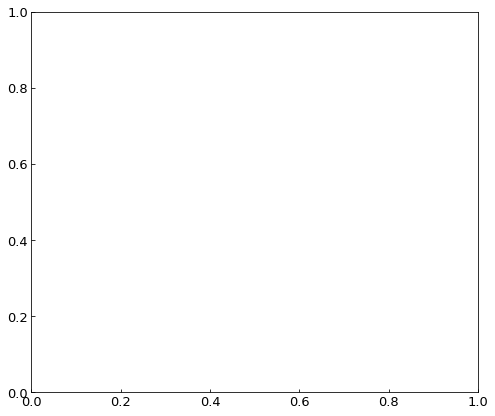

In [29]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))

tng_time = Table.read('TNG_snap_time.csv')
mass_list = np.array(np.ones(tree_length))
mass_sf_list = np.array(np.ones(tree_length))
mass_ratio_list = np.array(np.ones(tree_length))

for central_id_start in central_ids_start:
    tree = il.sublink.loadTree(basePath,snap_start,central_id_start,
                             fields=['SnapNum','SubfindID','SubhaloMass','SubhaloStellarPhotometricsMassInRad','SubhaloSFR'],onlyMPB=True)
    plt.plot(tree['SnapNum'][:50],np.array(tree['SubhaloStellarPhotometricsMassInRad'][:tree_length])/0.704,'k',alpha=0.2)
    
    mass_list = np.vstack([mass_list,np.array(tree['SubhaloStellarPhotometricsMassInRad'][:tree_length])/0.704])
    mass_sf = [tree['SubhaloStellarPhotometricsMassInRad'][tree_length]]
    mass_ratio = np.array(tree['SubhaloStellarPhotometricsMassInRad'][:tree_length])/mass_sf 
    
    for snap in np.arange(snap_start-tree_length, snap_start):
        mass_sf.append(mass_sf[-1]+0.1*tree['SubhaloSFR'][snap_start - snap]*
                       (tng_time['age'][snap]-tng_time['age'][snap-1]))

    mass_sf = np.array(mass_sf)
    mass_sf_list = np.vstack([mass_sf_list,mass_sf])
    mass_ratio_list = np.vstack([mass_ratio_list,mass_ratio])

mass_list = mass_list[1:]
mass_sf_list = mass_sf_list[1:]
mass_ratio_list = mass_ratio_list[1:]
                          
plt.plot(tree['SnapNum'][:tree_length],np.median(mass_list,axis=0),color='r',linewidth=2,label='Mass History')
plt.plot(np.flip(tree['SnapNum'][:tree_length],axis=0),np.median(mass_sf_list,axis=0),color='b',linewidth=2,label='estimate from SF')

plt.xlabel('snap', fontsize=20)
plt.ylabel('M_central', fontsize=20)
plt.yscale('log')
plt.xlim([22.5,72])
plt.legend(fontsize=18,frameon=False)
plt.savefig('mass_growth_central.png')

In [ ]:
plt.plot(tree['SnapNum'][:50],np.median(mass_ratio_list,axis=0),color='r',linewidth=2,label='$M_{SFR}/M_{stellar}$')

plt.xlabel('snap', fontsize=20)
plt.ylabel('M_central', fontsize=20)
plt.yscale('log')
plt.xlim([22.5,72])
plt.legend(fontsize=18,frameon=False)
plt.savefig('mass_growth_central.png')